# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='notebook_ims/style_tx_cat.png' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [221]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import tqdm

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [3]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

You can load in any images you want! Below, we've provided a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [5]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [7]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [97]:
# load in content and style image
#content = load_image('images/octopus.jpg').to(device)
# Resize style to match content, makes code easier
#style = load_image('images/hockney.jpg', shape=content.shape[-2:]).to(device)
content_path = "images/Starry night 2.jpg"
style_path = "images/Claude_Monet_30.jpg"

content = load_image(content_path).to(device)
style = load_image(style_path, shape=content.shape[-2:]).to(device)

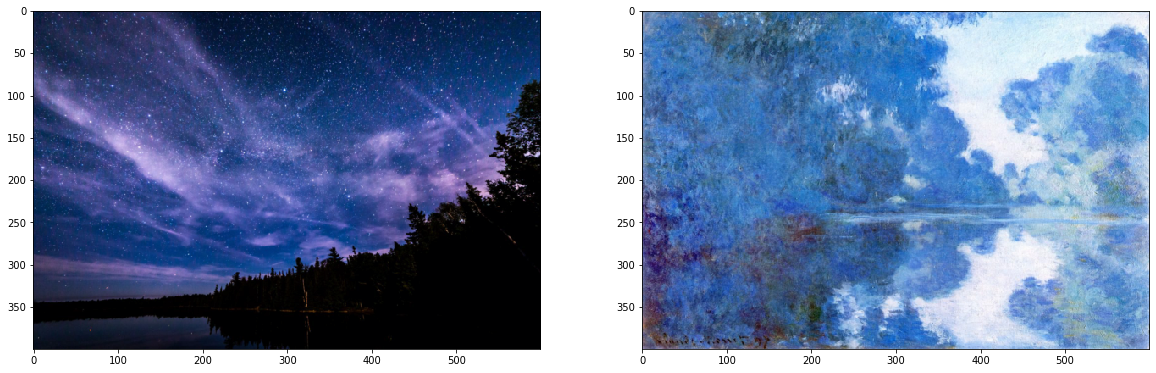

In [98]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [40]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

#### TODO: complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

The first layer (0) to `conv1_1` has been done for you, below.

In [272]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', # content representation
                  '28': 'conv5_1',
                  }
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

*Note: You can multiply two matrices using `torch.mm(matrix1, matrix2)`.*

#### TODO: Complete the `gram_matrix` function.

In [100]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    ## reshape it, so we're multiplying the features for each channel
    ## calculate the gram matrix
    batch_size, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [101]:
# Get the content feature and style feature through VGG
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Gram matrix for the style features
style_gms = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Cloning target image
target = content.clone().requires_grad_(True).to(device)

# Blank target image to see the different effect on the initialization
target_blank = torch.empty(target.shape, requires_grad=True, device="cuda")

---
## Loss and Weights

#### Individual Layer Style Weights

Below, you are given the option to weight the style representation at each relevant layer. It's suggested that you use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, you can expect to get _larger_ style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [102]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
# Content and Style weights
style_weights_layer = {'conv1_1': 1.,
                       'conv2_1': 0.8,
                       'conv3_1': 0.2,
                       'conv4_1': 0.2,
                       'conv5_1': 0.1}

content_weight = 1
style_weight = 1
tv_weight = 2

## Updating the Target & Calculating Losses

You'll decide on a number of steps for which to update your image, this is similar to the training loop that you've seen before, only we are changing our _target_ image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to you to set! **I recommend using at least 2000 steps for good results.** But, you may want to start out with fewer steps if you are just testing out different weight values or experimenting with different images.

Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 
> You'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> Later, you'll see that this value is normalized by the size of the layer.\

#### Total Variation Denoising

Using the total variation denoising technique to reduce the noise and artifacts during the reconstruction process.

#### Total Loss

The final total loss would be the sum of the above three kinds of losses times their respective weights.


In [271]:
def stylize(content_path, style_path, out_path, target_init = "clone", out_format = "image-only", 
            lr = 0.003, show_every = 500, steps = 5000, content_weight = 7.5, style_weight = 1e2, tv_weight = 2e2):
    """
    Transfer the style of the style image to the content image with pre-trained vgg-19 arch
    itect without final classifier layer, uses 'conv1_1, conv2_1, conv3_1, conv4_1, conv5_1'
    from the style image as the style layer , 'conv4_2' from the content image as the conte
    nt layer. The network uses Adam as the optimizer and optimizes the total loss of the ta
    rget image.
    
    During the training process, the network remains static and won't be trained on. The ta
    rget image will keep get updated with iterations within the network.
    
    Args:
        target_init (str): The initialization method for the target image. "clone" initiali
        zes a target image that is identical to the content image. "blank" initializes the 
        target image as a blank image. "random" initializes the target image with random no
        ises.
        content_path (str): The directory path to the content image.
        style_path(str): The directory path to the style image.
        out_path(str): The directory path of the output image.
        out_format(str): The output format with two possible methods: "image-only" exports 
        only the output, "comparison" exports the comparison between the content image, st
        yle image and the output image.
        lr: learning rate of the optimizer.
        show_every: The frequency to show the progress, loss and intermediate result. 
        steps: The number of iterations.
        content_weight: The weight of the content loss.
        style_weight: The weight of the style loss.
        tv_weight: The weight of the total variation loss for denoising.
    Raises:
        ValueError: 
            When the target_init receives an unexpected method.
            When the out_format receives an unexpected format
    """
    #see if cuda is available, if not, use cpu instead (Could be extremely slow)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #loading content and style images
    content = load_image(content_path).to(device)
    style = load_image(style_path, shape=content.shape[-2:]).to(device)
    print("=======================Image Loading Completed===========================")
    
    #define target
    if target_init == "clone":
        target = content.clone().requires_grad_(True).to(device)
        # maintain the weights constant as the target will be initialized as the content image
    elif target_init == "blank":
        target = torch.full(content.shape,fill_value = 0.5, requires_grad=True, device=device)
        # change the weights to be a more aggresive degree 
    elif target_init == "random":
        target = torch.rand(content.shape, requires_grad=True, device=device)
    else:
        raise ValueError('Unexpected Initialization Method{}'.format(target_init))
    print("=======================Target Definition Completed, Mode: {}===========================".format(target_init))
    
    #optimizer
    lr = lr if target_init == "clone" else min(lr*10, 0.1)
    optimizer = optim.Adam([target], lr = lr)
    print("=======================Optimizer: Adam, Learning Rate:{}===========================".format(lr))
    
    #get the content and style features
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)
    #style gram matrices
    style_gms = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    print("=======================Feature Extraction And Gram Matrix Calculation Completed===========================")
    
    for ii in tqdm.tqdm(range(1, steps + 1)):
        # use different weight value for different initialization methods
        if target_init == "blank" or target_init == "random":
            if ii <= steps * 0.2:           
                content_weight = 1
                style_weight = 0.01
                tv_weight = 2
            else: 
                content_weight = 10
                style_weight = 1e2
                tv_weight = 20
        # overview of initialization
        if ii == 1:
            if target_init == "clone":
                print("=======================Initial Setting===========================",
                      "\ncontent weight:{}".format(content_weight),
                      "\nstyleweight:{}".format(style_weight),
                      "\ntotal variation denoising weight:{}".format(tv_weight))
            else:
                print("=======================Initial Setting: Reconstructing Content First===========================",
                      "\ncontent weight:{}".format(content_weight),
                      "\nstyleweight:{}".format(style_weight),
                      "\ntotal variation denoising weight:{}".format(tv_weight))
        elif ii == steps * 0.2:
            if target_init == "random" or target_init == "blank":
                print("=======================Intermediate Setting: Constructing Style===========================",
                      "\ncontent weight:{}".format(content_weight),
                      "\nstyleweight:{}".format(style_weight),
                      "\ntotal variation denoising weight:{}".format(tv_weight))
        
        ############################ Loss calculation #########################################
        
        # extract target features
        target_features = get_features(target, vgg)
        # content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
        # style loss
        style_loss = 0
        for layer in style_weights_layer:
            target_features_layer = target_features[layer]
            batch_size, d, h, w = target_features_layer.shape

            # gram matrix of target image
            target_gram = gram_matrix(target_features_layer)
            # gram matrix of style image
            style_gram = style_gms[layer]
            layer_style_loss = style_weights_layer[layer] * torch.mean((target_gram - style_gram) ** 2)
            style_loss +=  layer_style_loss / (d * h * w)
            
        # total variation denoising
        batch_size = target.size()[0]
        h_x = target.size()[2]
        w_x = target.size()[3]
        count_h =  (target.size()[2]-1) * target.size()[3]
        count_w = target.size()[2] * (target.size()[3] - 1)
        h_tv = torch.pow((target[:,:,1:,:]-target[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((target[:,:,:,1:]-target[:,:,:,:w_x-1]),2).sum()

        tv_loss =  2 * (h_tv/count_h + w_tv/count_w) / batch_size
        total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss

        # Update the target
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if ii % show_every == 0:
            print("Total loss:", total_loss.item(), "\nContent loss:", content_loss.item(),"\nStyle loss:", style_loss.item(), "\nTV loss:", tv_loss.item())
            print("Progress:{}%".format(round(float(ii/steps), 3) * 100))
            plt.imshow(im_convert(target))
            plt.show()
    
    # exporting final result
    if target_init == "clone":
    # reverse normalization
        target = target.detach().cpu().view(-1, h_x, w_x) 
        target_out = target.new(*target.size())
        std = [0.229, 0.224, 0.225]
        mean = [0.485, 0.456, 0.406]

        target_out[0, :, :] = target[0, :, :] * std[0] + mean[0]
        target_out[1, :, :] = target[1, :, :] * std[1] + mean[1]
        target_out[2, :, :] = target[2, :, :] * std[2] + mean[2]
        target_out = target_out.clamp(0,1)
    else:
        target_out = target
    if out_format == "image-only":
        # export only the result of style transfer
        target_out = transforms.ToPILImage("RGB")(target_out)
        target_out.save(out_path)
    elif out_format == "comparison":
        # export the comparison of content, style and results of style transfer
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 30))
        ax1 = plt.subplot(212)          
        ax1.imshow(im_convert(target))
        ax1.axis('off')
        ax1.set_title('Output', size = 40)

        ax2 = plt.subplot(221)           
        ax2.imshow(im_convert(content))
        ax2.axis('off')
        ax2.set_title('Content', size = 20)

        ax3 = plt.subplot(222)  
        ax3.imshow(im_convert(style))
        ax3.axis('off')
        ax3.set_title('Style', size = 20)
        plt.subplots_adjust(bottom=0.1, right=0.8, top=1.15)
        fig.tight_layout(pad = 1)
        plt.savefig(out_path)
    else:
        raise ValueError('Unexpected Output Format{}'.format(out_format))

Transfer the style of the style image to the content image with pre-trained vgg-19 architect without final classifier layer, uses 'conv1_1, conv2_1, conv3_1, conv4_1, conv5_1' from the style image as the style layer , 'conv4_2' from the content image as the content layer. The network uses Adam as the optimizer and optimizes the total loss of the target image.
    
During the training process, the network remains static and won't be trained on. The target image will keep get updated with iterations within the network.

    Arguments:
    target_init (str): The initialization method for the target image. "clone" initializes a target image that is identical to the content image. "blank" initializes the target image as a blank image. "random" initializes the target image with random noises.
    content_path (str): The directory path to the content image.
    style_path(str): The directory path to the style image.
    out_path(str): The directory path of the output image.
    out_format(str): The output format with two possible methods: "image-only" exports only the output, "comparison" exports the comparison between the content image, style image and the output image.
    lr: learning rate of the optimizer.
    show_every: The frequency to show the progress, loss and intermediate result. 
    steps: The number of iterations.
    content_weight: The weight of the content loss.
    style_weight: The weight of the style loss.
    tv_weight: The weight of the total variation loss for denoising.

## Stylizing Images

  0%|                                                                                 | 3/7000 [00:00<05:02, 23.14it/s]

=======================Image Loading Completed===========================
=======================Target Definition Completed, Mode: clone===========================
=======================Optimizer: Adam, Learning Rate:0.003===========================
=======================Feature Extraction And Gram Matrix Calculation Completed===========================
=======================Initial Setting=========================== 
content weight:7.5 
styleweight:100.0 
total variation denoising weight:200.0


  7%|█████▌                                                                         | 498/7000 [00:36<09:28, 11.44it/s]

Total loss: 4371.52685546875 
Content loss: 9.512943267822266 
Style loss: 39.774986267089844 
TV loss: 1.6134047508239746
Progress:7.1%


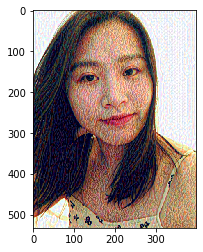

 14%|███████████▎                                                                   | 998/7000 [01:19<08:27, 11.82it/s]

Total loss: 2105.59033203125 
Content loss: 9.748881340026855 
Style loss: 16.555707931518555 
TV loss: 1.8845144510269165
Progress:14.299999999999999%


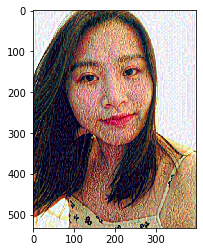

 21%|████████████████▋                                                             | 1498/7000 [02:02<07:46, 11.80it/s]

Total loss: 1413.3824462890625 
Content loss: 9.71452522277832 
Style loss: 9.666690826416016 
TV loss: 1.8692724704742432
Progress:21.4%


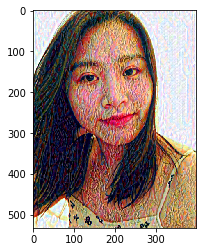

 29%|██████████████████████▎                                                       | 1999/7000 [02:45<07:07, 11.70it/s]

Total loss: 1070.614990234375 
Content loss: 9.552671432495117 
Style loss: 6.417686462402344 
TV loss: 1.7860066890716553
Progress:28.599999999999998%


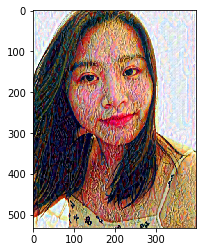

 36%|███████████████████████████▊                                                  | 2498/7000 [03:28<06:20, 11.84it/s]

Total loss: 863.153076171875 
Content loss: 9.339174270629883 
Style loss: 4.538589954376221 
TV loss: 1.696251392364502
Progress:35.699999999999996%


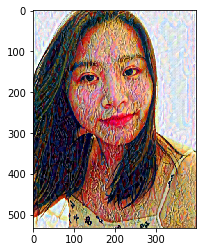

 43%|█████████████████████████████████▍                                            | 2998/7000 [04:11<05:39, 11.80it/s]

Total loss: 722.8267211914062 
Content loss: 9.100325584411621 
Style loss: 3.3082823753356934 
TV loss: 1.6187301874160767
Progress:42.9%


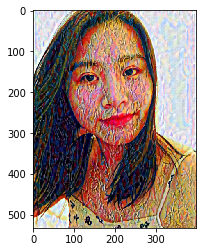

 50%|██████████████████████████████████████▉                                       | 3499/7000 [04:54<04:56, 11.79it/s]

Total loss: 622.7152099609375 
Content loss: 8.870979309082031 
Style loss: 2.4485862255096436 
TV loss: 1.5566210746765137
Progress:50.0%


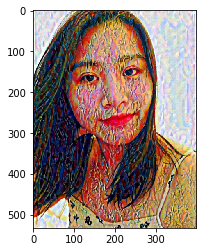

 57%|████████████████████████████████████████████▌                                 | 3999/7000 [05:37<04:17, 11.67it/s]

Total loss: 549.315673828125 
Content loss: 8.639486312866211 
Style loss: 1.8297739028930664 
TV loss: 1.5077109336853027
Progress:57.099999999999994%


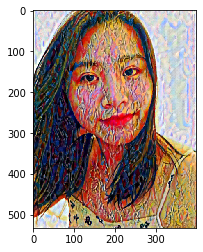

 64%|██████████████████████████████████████████████████▏                           | 4499/7000 [06:20<03:31, 11.80it/s]

Total loss: 494.8780517578125 
Content loss: 8.420356750488281 
Style loss: 1.3794196844100952 
TV loss: 1.4689170122146606
Progress:64.3%


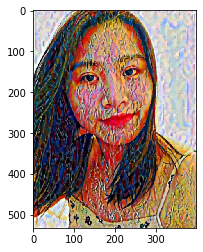

 71%|███████████████████████████████████████████████████████▋                      | 4999/7000 [07:03<02:49, 11.78it/s]

Total loss: 454.550537109375 
Content loss: 8.222001075744629 
Style loss: 1.0542628765106201 
TV loss: 1.4372962713241577
Progress:71.39999999999999%


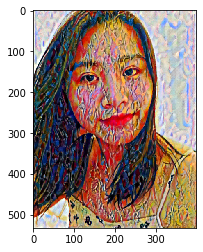

 79%|█████████████████████████████████████████████████████████████▎                | 5499/7000 [07:46<02:07, 11.74it/s]

Total loss: 424.87591552734375 
Content loss: 8.034692764282227 
Style loss: 0.8245886564254761 
TV loss: 1.4107842445373535
Progress:78.60000000000001%


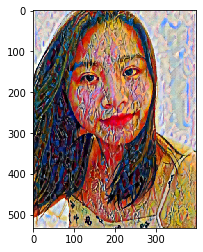

 83%|████████████████████████████████████████████████████████████████▌             | 5790/7000 [08:11<01:42, 11.78it/s]


KeyboardInterrupt: 

In [274]:
stylize(content_path = "images/douji.jpg", style_path = "images/Vassily_Kandinsky,_1913_-_Composition_7.jpg", out_path = "douji4.png", target_init = "clone", out_format = "image-only", steps = 7000)